# Mentoría 'de cómo clasificar en géneros a las canciones'
## Práctico II : Análisis de features de audio

**Antes de empezar:**
- [Instalar spaCy y el modelo de lenguaje con el que van a trabajar](https://spacy.io/models#quickstart)

**Consideraciones:**
- Se evalúa el estilo y prolijidad del código.
- Se permite hacer trabajo extra, siempre y cuando las actividades básicas estén resueltas.

### Librerías

In [1]:
import sys
in_colab = 'google.colab' in sys.modules

if in_colab:
  !pip install pandas
  !pip install spacy
  !pip install nltk
  !pip install lyricsgenius

# Agregar las librerías extra que se utilicen en esta celda y la siguiente

     |████████████████████████████████| 92kB 5.7MB/s 
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


### Dependencias y acceso al API

In [2]:
import pandas as pd
import numpy as np
import spacy
import en_core_web_sm
import nltk
import lyricsgenius
from collections import Counter
from nltk import ngrams
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
nlp = en_core_web_sm.load()

genius = lyricsgenius.Genius("oHbS40cAj6tO1Y7zH60tdWAJMTgV6YjszA8LWMUBiFrzgM7Tg3d7_iUaYB1YBLUO")
genius.remove_section_headers = True

### 1) Plantear una pregunta que quieran responder con estos datos

Las preguntas pueden ser por ejemplo: 
- ¿Por qué este artista destaca dentro de su género?
- ¿Por qué no lo hace?
- ¿Por qué un género musical es más escuchado que otro?

Sin embargo, pueden usar cualquier afirmación que hayan leído en internet y que se pueda responder con los datos este trabajo para validarla o rechazarla.

**PREGUNTA:** <p style="color:DodgerBlue;">¿Cual sera el contenido de las letras de una banda de trash metal en comparacion con una banda de rock/pop?</p>

### 2) Obtener datos para responder la pregunta

Para extraer las letras de las canciones usaremos la [API de MusiXmatch](https://developer.musixmatch.com/documentation) a través de su [wrapper en Python](https://github.com/hudsonbrendon/python-musixmatch).
Una vez obtenidas las letras de las canciones, las procesaremos de la siguiente manera:
1. Tokenizar
2. Remover las [stop-words](https://es.wikipedia.org/wiki/Palabra_vac%C3%ADa)
3. [Lema](https://es.wikipedia.org/wiki/Lema_(ling%C3%BC%C3%ADstica))tizar las palabras que hayan quedado
4. Organizar todo en un DataFrame de la forma Canción-Artista-Letra donde Letra es el resultado de 3.

**Recomendación** : Usar un dataframe para su artista y otro para la competencia si es que eligierone esa opción, les va a ahorrar tiempo.

**Aclaración** : Si plantearon una pregunta que no requiera los datos de la consigna, obtengan esos datos.

In [4]:
def get_lyrics_from_genius(track_name, artist_name):
  try:
    my_lyrics = genius.search_song(title=track_name, artist=artist_name)
    lyrics_txt = my_lyrics.lyrics
  except:
    lyrics_txt = ""
  return lyrics_txt

In [5]:
def create_df_for_artist(artist_name):
    my_features = ['song_title', 'lyrics']
    df = pd.DataFrame(columns=my_features)
    try:
        songs_list = genius.search_artist(artist_name)
        for song in songs_list.songs:
            my_row = {}
            my_row['song_title'] = song.title
            #my_row['lyrics'] = song.lyrics
            my_lyrics = get_lyrics_from_genius(song.title, artist_name)
            my_row['lyrics'] = my_lyrics
            df = df.append(my_row, ignore_index=True)
# A continuacion se eliminan canciones repetidas
        track_name_clear = []
        for i in range(df.shape[0]):
            my_str = df.iloc[i].song_title.split('-')[0]
            my_str = my_str.split('(')[0]
            my_str = my_str.strip().lower()
            track_name_clear.append(my_str)
        df['track_name_norm'] = track_name_clear
        df.sort_values('track_name_norm', inplace=True)
        df.drop_duplicates(subset='track_name_norm', keep='first', inplace=True)
    except:
        print("ERROR during search")
    return df

In [6]:
def get_lemma(my_lyrics):
  doc = nlp(my_lyrics)
  my_str=""
  for token in doc:
    if token.is_alpha & ~token.is_stop: 
      my_str += token.lemma_ +" "
  return my_str

In [7]:
def add_lemmas_to_df(df, artist_name):
    lemmas = []
    total_lemmas=""
    for i in range(df.shape[0]):
        my_lyrics = df.iloc[i].lyrics
        my_lemmas = ""
        if len(my_lyrics) > 0:
            my_lemmas = get_lemma(my_lyrics)
        lemmas.append(my_lemmas)
        total_lemmas += my_lemmas
    df['lemmas'] = lemmas
    return df, total_lemmas

In [12]:
# Banda Trash Metal
ARTIST_ONE = 'Megadeth'
df_artist_one = create_df_for_artist(ARTIST_ONE)


Searching for songs by Megadeth...

Song 1: "Holy Wars...The Punishment Due"
Song 2: "À Tout le Monde"
Song 3: "Tornado of Souls"
Song 4: "Symphony of Destruction"
Song 5: "Peace Sells"
Song 6: "In My Darkest Hour"
Song 7: "Sweating Bullets"
Song 8: "Hangar 18"
Song 9: "Rust in Peace...Polaris"
Song 10: "Five Magics"
Song 11: "Mechanix"
Song 12: "Take No Prisoners"
Song 13: "Trust"
Song 14: "Dystopia"
Song 15: "The Conjuring"
Song 16: "Hook in Mouth"
Song 17: "Countdown to Extinction"
Song 18: "Set the World Afire"
Song 19: "Lucretia"
Song 20: "Good Mourning/Black Friday"
Song 21: "Angry Again"
Song 22: "Wake Up Dead"
Song 23: "Conquer or Die!"
Song 24: "Dawn Patrol"
Song 25: "Skin o’ My Teeth"
Song 26: "She-Wolf"
Song 27: "Poison Was the Cure"
Song 28: "Killing Is My Business... and Business Is Good!"
Song 29: "Last Rites / Loved to Deth"
Song 30: "Youthanasia"
Song 31: "Foreclosure of a Dream"
Song 32: "My Last Words"
Song 33: "Victory"
Song 34: "These Boots"
Song 35: "The Threat Is 

In [13]:
#Adding lemmas to dataframe
df_artist_one, lemmas_artist_one = add_lemmas_to_df(df_artist_one, ARTIST_ONE)
df_artist_one

,song_title,lyrics,track_name_norm,lemmas
95,"1,000 Times Goodbye",The tides of change pulled us apart\nI feel a ...,"1,000 times goodbye",tide change pull apart feel familiar pain like...
112,"1,320'","Grinding my teeth, white knuckles grasp at the...","1,320'",grind tooth white knuckle grasp wheel rush ava...
88,13,Thirteen times I went to the well\nTo draw my ...,13,thirteen time go draw thought gather tell like...
92,44 Minutes,,44 minutes,
74,502,"""Pull over, shithead. This is the cops!""\nFull...",502,pull shithead cop tank pocket line cash thrott...
...,...,...,...,...
153,Whose Life (Is It Anyways?),"Ooh, you're just in time to get inside my head...",whose life,ooh time inside head ooh war word underneath s...
173,Wrecker,"It doesn't matter what car you drive, she'll w...",wrecker,matter car drive wreck matter sleep night wrec...
29,Youthanasia,Who'd believe with the way things are here?\nW...,youthanasia,believe way thing tell people live believe spe...
168,You’re Dead,When someone becomes nothing to anyone\nAll fe...,you’re dead,feeling die know send stick stone say crush bo...


In [10]:
# Banda Rock/Pop
ARTIST_2 = 'Toto'
df_artist_2 = create_df_for_artist(ARTIST_2)
#Adding lemmas to dataframe
df_artist_2, lemmas_artist_2 = add_lemmas_to_df(df_artist_2, ARTIST_2)
df_artist_2

Searching for songs by Toto...

Song 1: "Africa"
Song 2: "Hold the Line"
Song 3: "Rosanna"
Song 4: "Georgy Porgy"
Song 5: "I’ll Be Over You"
Song 6: "I Won’t Hold You Back"
Song 7: "99"
Song 8: "I Will Remember"
Song 9: "Lea"
Song 10: "Stop Loving You"
Song 11: "Pamela"
Song 12: "Hydra"
Song 13: "Alone"
Song 14: "Struck by Lightning"
Song 15: "Make Believe"
Song 16: "Mushanga"
Song 17: "Good for You"
Song 18: "Hash Pipe"
Song 19: "Waiting For Your Love"
Song 20: "Stranger In Town"
Song 21: "I’ll Supply the Love"
Song 22: "St. George and the Dragon"
Song 23: "Spanish Sea"
Song 24: "Afraid of Love"
Song 25: "Girl Goodbye"
Song 26: "It’s a Feeling"
Song 27: "Don’t Chain My Heart"
Song 28: "Lovers In the Night"
Song 29: "Home Of The Brave"
Song 30: "Bottom Of Your Soul"
Song 31: "Angela"
Song 32: "Orphan"
Song 33: "Till The End"
Song 34: "In a Little While"
Song 35: "Melanie"
Song 36: "We Made It"
Song 37: "Out of Love"
Song 38: "Wings of Time"
Song 39: "The Road Goes On"
Song 40: "Anna"
S

,song_title,lyrics,track_name_norm,lemmas
40,2 Hearts,"You said you would wait for me, but something ...",2 hearts,say wait go wrong house picture go know come d...
57,21st Century Blues,Used to be you could trust what you heard\nThe...,21st century blues,trust hear channel news absurd word set free t...
6,99,"99, I've been waiting so long\nOh 99, where di...",99,wait long Oh wrong oh love break heart oh apar...
118,A Million Miles Away,I don't want to know the reason why you don't ...,a million miles away,want know reason love want know reason care wa...
85,A Secret Love,,a secret love,
...,...,...,...,...
37,Wings of Time,"My faithful companion, I've lost my way once a...",wings of time,faithful companion lose way prisoner darkness ...
143,With a little help from my friends - live,,with a little help from my friends,
44,Without Your Love,It's late at night\nNothin's feelin' right\nSi...,without your love,late night nothing feelin right go away think ...
41,You Are the Flower,"You never lose a minute, if in it there is lov...",you are the flower,lose minute love old man time pull well depend...


### 3) Encontrar los n-gramas (n= 1, 2) más comunes y usarlos en gráficos.
Utilizando las librerías de la celda de abajo obtendremos los conjuntos de 1 y 2 palabras más comunes para cada artista con el que trabajaremos. Luego usaremos los unigramas para graficar una [word-cloud](https://i.imgur.com/8I8aJ1N.png) y un gráfico de distribución de frecuencia para unigramas y bigramas por autor (o de la forma que se adapte a su pregunta).

In [14]:
nltk.download('punkt')
 
# Function to generate n-grams from sentences.
def extract_ngrams(data, num):
    n_grams = ngrams(nltk.word_tokenize(data), num)
    return [ ' '.join(grams) for grams in n_grams]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [15]:
#Unigrama y bigrama para ARTISTA ONE
ngram_1 = extract_ngrams(lemmas_artist_one, 1)
ngram_2 = extract_ngrams(lemmas_artist_one, 2)
counter_n1 = Counter(ngram_1)
counter_n2 = Counter(ngram_2)
df_n1 = pd.DataFrame(counter_n1.items(), columns=['word', 'count_of_1'])
df_n2 = pd.DataFrame(counter_n2.items(), columns=['word', 'count_of_1'])
df_n1.sort_values('count_of_1', ascending=False, inplace=True)
df_n2.sort_values('count_of_1', ascending=False, inplace=True)

In [16]:
#Unigrama y bigrama para ARTISTA TWO
ngram_1 = extract_ngrams(lemmas_artist_2, 1)
ngram_2 = extract_ngrams(lemmas_artist_2, 2)
counter_n1 = Counter(ngram_1)
counter_n2 = Counter(ngram_2)
df_n3 = pd.DataFrame(counter_n1.items(), columns=['word', 'count_of_2'])
df_n4 = pd.DataFrame(counter_n2.items(), columns=['word', 'count_of_2'])
df_n3.sort_values('count_of_2', ascending=False, inplace=True)
df_n4.sort_values('count_of_2', ascending=False, inplace=True)

### 4) Escribir un informe

Este informe tiene que describir qué datos que obtuvieron, el volumen de estos (# de canciones del artista, # de canciones de la competencia, etc), una explicación de cómo estos se relacionan con la pregunta planteada, cómo ayudan a responderla y los resultados que obtuvieron. Usar la celda de abajo con formato markdown.

### INFORME

Como primer banda, se tomo como ejemplo la banda de trash metal **Megadeth**
Los features en el dataframe de cada artista responde a la sgte descripcion:
- song_title = titulo de la cancion
- lyrics = letra completa de la cancion
- track_name_norm = titulo de la cancion normalizado, se utilio esta columna para eliminar tracks repetidos, ya que se observo que al armar el dataframe con la discografia disponible de la banda se encontraron las mismas canciones en diferentes albumes.
- lemmas = lemmas extraidos de la cancion

El dataframe para la banda **Megadeth** contiene 200 canciones (de las cuales hay 5 a las que la API Genius no encontro la letra)

In [17]:
df_artist_one.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 95 to 1
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   song_title       200 non-null    object
 1   lyrics           200 non-null    object
 2   track_name_norm  200 non-null    object
 3   lemmas           200 non-null    object
dtypes: object(4)
memory usage: 7.8+ KB


In [18]:
df_artist_one[df_artist_one['lyrics'] == ""]

,song_title,lyrics,track_name_norm,lemmas
92,44 Minutes,,44 minutes,
192,Absolution (Demo),,absolution,
176,All I Want,,all i want,
107,Amerikhastan,,amerikhastan,
212,"Anarchy In The U.K. (Live from Wembley Arena, ...",,anarchy in the u.k.,
...,...,...,...,...
32,Victory,,victory,
21,Wake Up Dead,,wake up dead,
44,Washington Is Next!,,washington is next!,
98,When,,when,


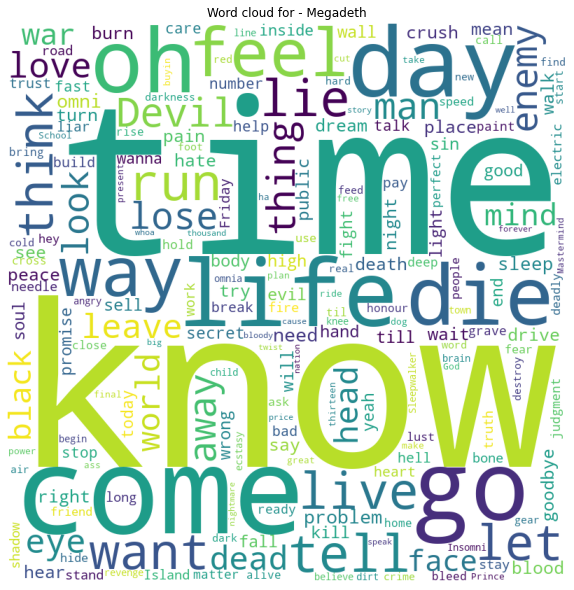

In [19]:
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', collocations=False,
                min_font_size = 10).generate(lemmas_artist_one) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None)
plt.title('Word cloud for - '+ ARTIST_ONE)
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

Como puede observarse en el wordcloud para la banda **Megadeth**, aparecen palabras que denotan una connotacion más "oscura" en las letras como demonio (evil, devil), infierno (hell), muerte/morir (death, die), matar (kill), destruir (destroy), mentir (lie), tumba (grave), negro (black)

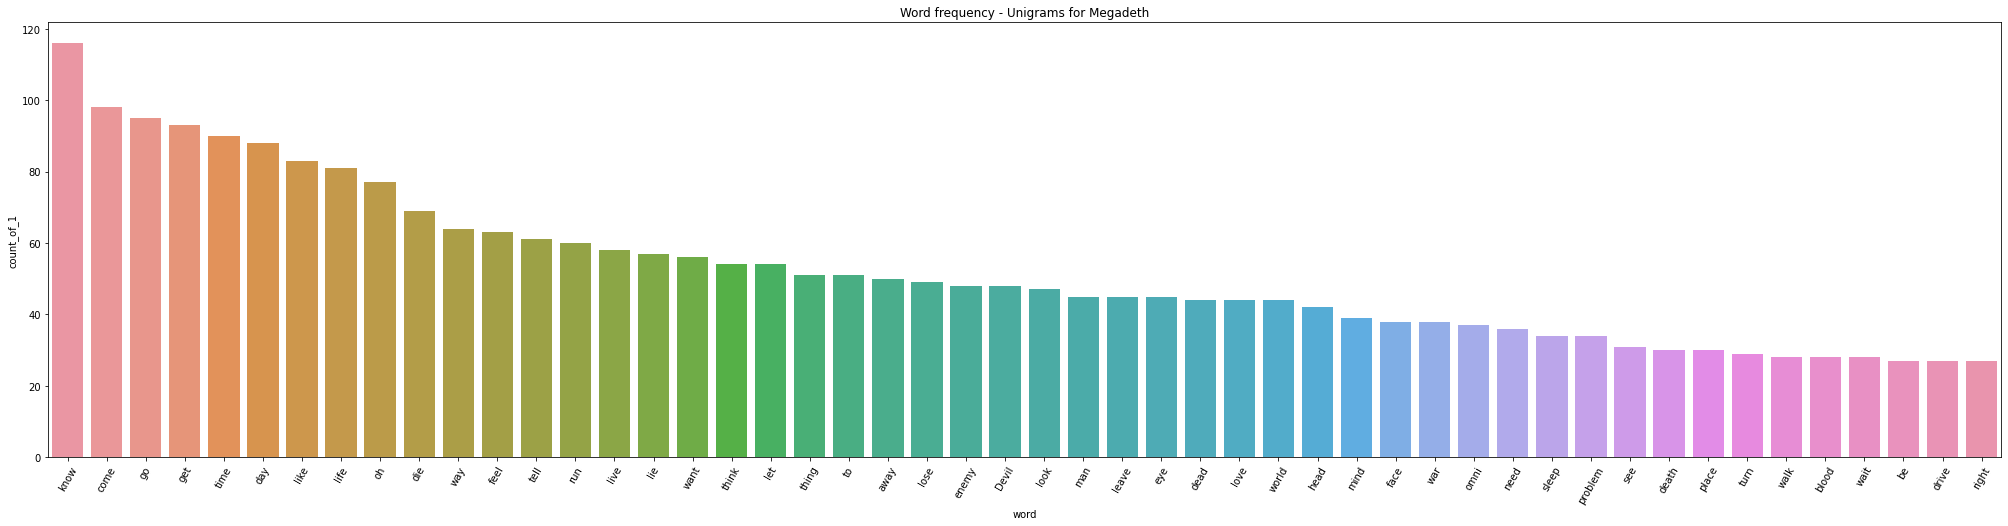

In [21]:
plt.figure(figsize = (35,8))
N=50
plt.title('Word frequency - Unigrams for ' + ARTIST_ONE)
plot = sns.barplot(x  = df_n1[:N].word, y = df_n1[:N].count_of_1)
for item in plot.get_xticklabels():
    item.set_rotation(60)
plt.show()

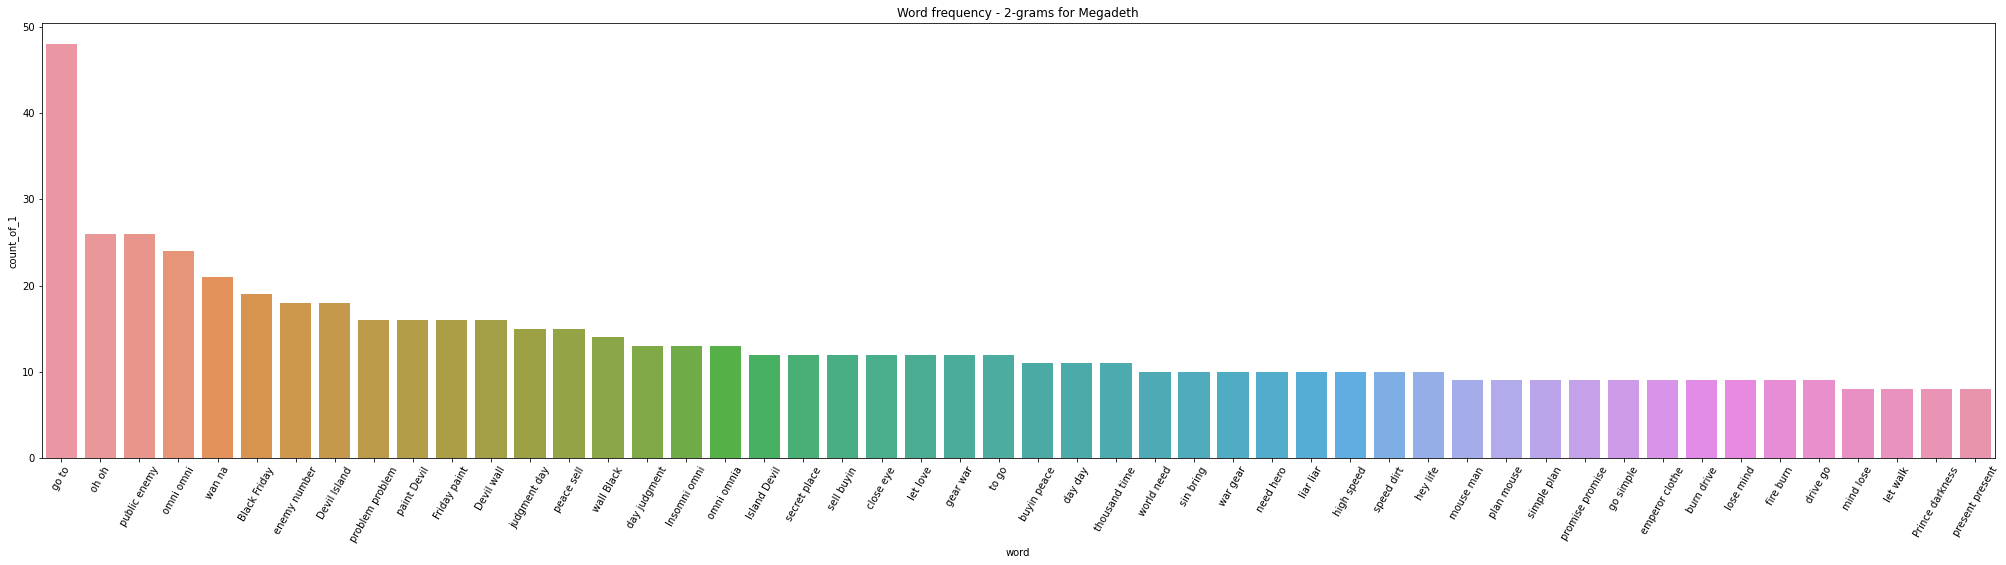

In [22]:
plt.figure(figsize = (35,8))
N=50
plt.title('Word frequency - 2-grams for ' + ARTIST_ONE)
plot = sns.barplot(x  = df_n2[:N].word, y = df_n2[:N].count_of_1)
for item in plot.get_xticklabels():
    item.set_rotation(60)
plt.show()

Como segunda banda para la comparacion, se tomo como ejemplo la banda de rock/pop **Toto**

El dataframe para la banda **Toto** contiene 194 canciones


In [23]:
df_artist_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 194 entries, 40 to 117
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   song_title       194 non-null    object
 1   lyrics           194 non-null    object
 2   track_name_norm  194 non-null    object
 3   lemmas           194 non-null    object
dtypes: object(4)
memory usage: 7.6+ KB


In [24]:
df_artist_2[df_artist_2['lyrics'] == ""]

,song_title,lyrics,track_name_norm,lemmas
85,A Secret Love,,a secret love,
56,A Thousand Years,,a thousand years,
23,Afraid of Love,,afraid of love,
0,Africa,,africa,
81,All Us Boys,,all us boys,
...,...,...,...,...
165,Watching the Detectives,,watching the detectives,
155,We’ll Keep On Running,,we’ll keep on running,
68,While My Guitar Gently Weeps,,while my guitar gently weeps,
65,White Sister,,white sister,


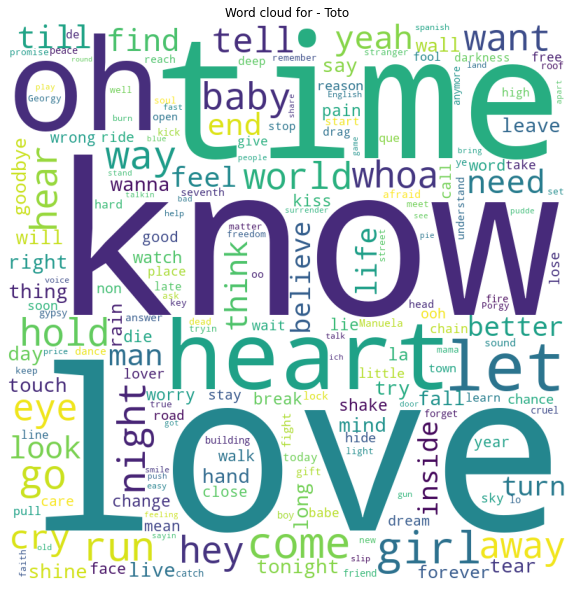

In [25]:
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', collocations=False,
                min_font_size = 10).generate(lemmas_artist_2) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None)
plt.title('Word cloud for - '+ ARTIST_2)
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

Como puede observarse en el wordcloud para la banda **Toto**, a diferencia de la otra banda no aparecen palabras que denotan una connotacion "oscura" sino más bien "soft" como amor (love), corazon (heart), amigo (friend)


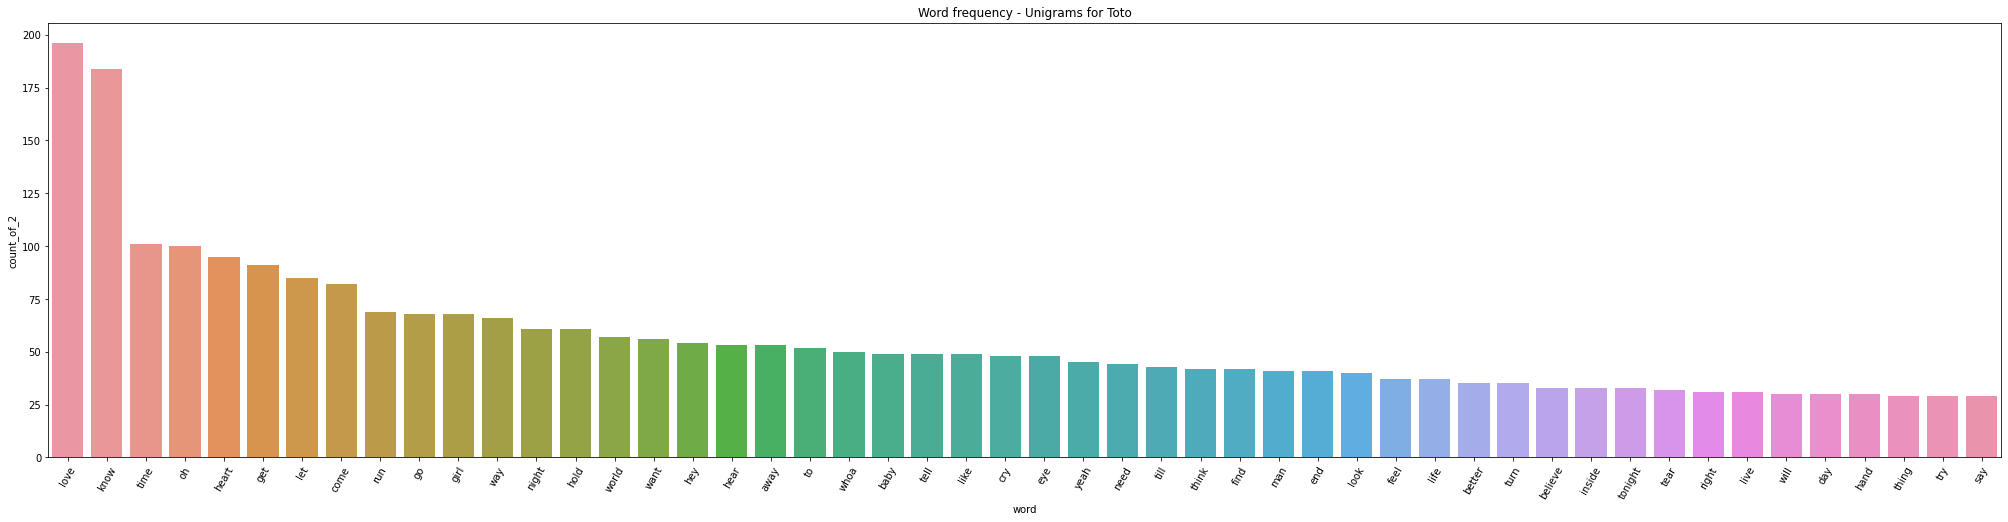

In [26]:
plt.figure(figsize = (35,8))
N=50
plt.title('Word frequency - Unigrams for ' + ARTIST_2)
plot = sns.barplot(x  = df_n3[:N].word, y = df_n3[:N].count_of_2)
for item in plot.get_xticklabels():
    item.set_rotation(60)
plt.show()

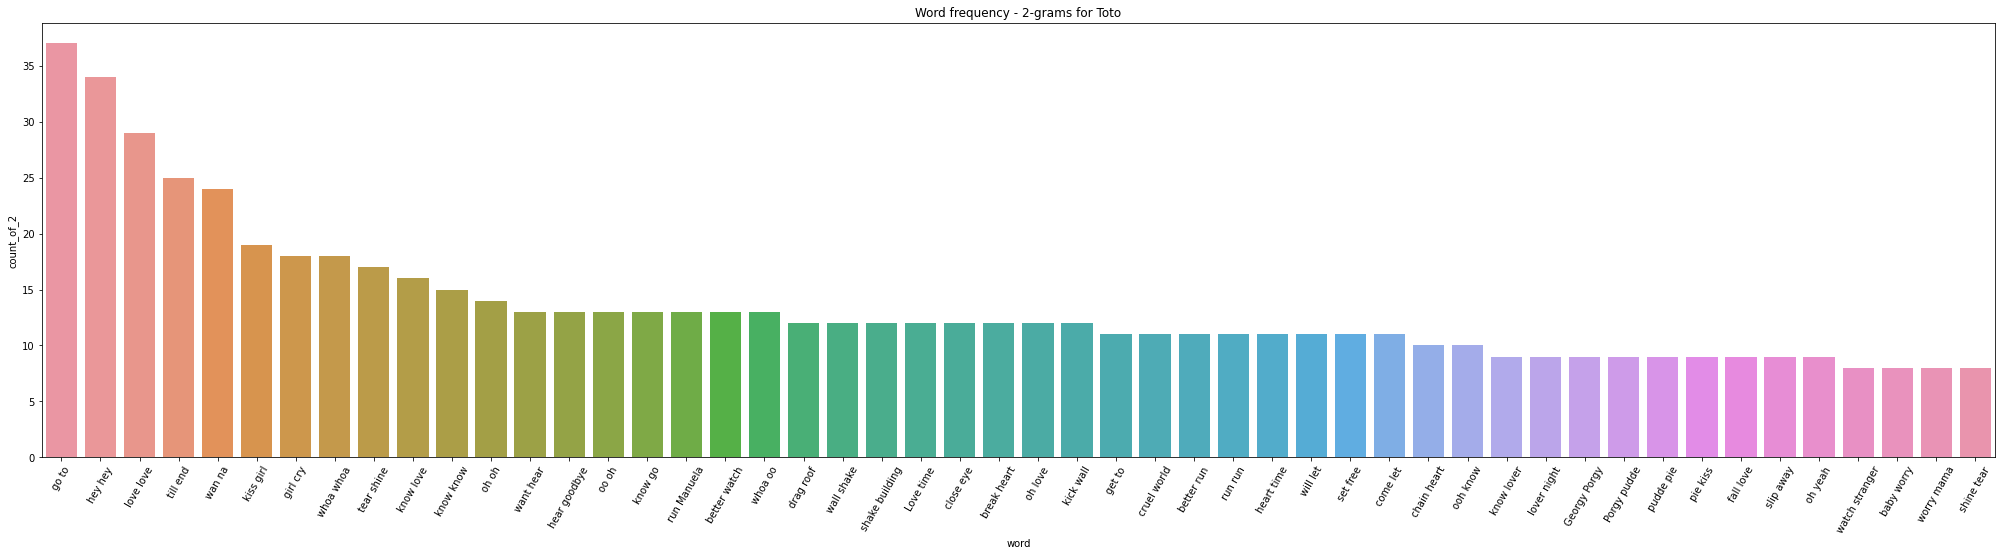

In [27]:
plt.figure(figsize = (35,8))
N=50
plt.title('Word frequency - 2-grams for ' + ARTIST_2)
plot = sns.barplot(x  = df_n4[:N].word, y = df_n4[:N].count_of_2)
for item in plot.get_xticklabels():
    item.set_rotation(60)
plt.show()

Se observa que la frecuencia de "love" para la banda **Toto** figura en 2do lugar, mientras que para **Megadeth** figura en la posicion 21

Veamos a continuacion qué lemmas tienen en comun ambas bandas y en qué medida

In [28]:
final_test = pd.merge(df_n1, df_n3, on='word')
final_test['totales'] = final_test.count_of_1 + final_test.count_of_2
final_test.sort_values('totales', ascending=False, inplace=True)
final_test

,word,count_of_1,count_of_2,totales
0,know,116,184,300
29,love,44,196,240
4,time,90,101,191
3,get,93,91,184
1,come,98,82,180
...,...,...,...,...
581,valley,1,1,2
644,meaning,1,1,2
583,rhyme,1,1,2
641,spare,1,1,2


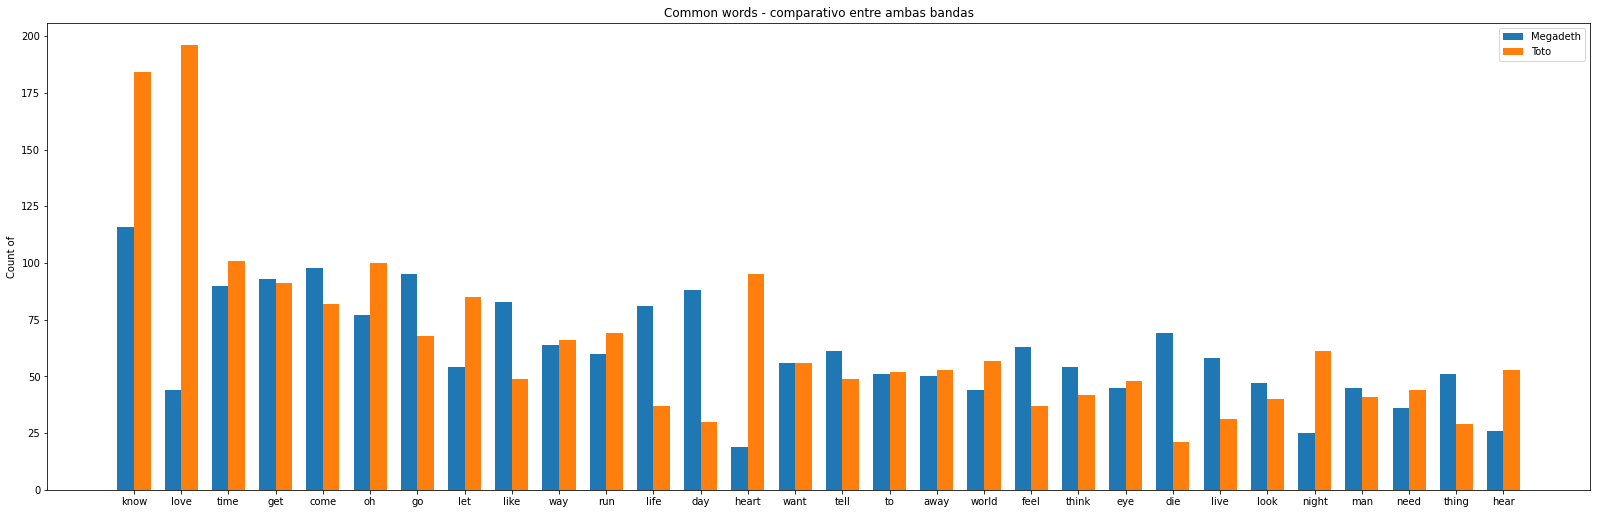

In [30]:
N = 30
count_of_1 = final_test[:N].count_of_1
count_of_2 = final_test[:N].count_of_2
x = np.arange(N)  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, count_of_1, width, label=ARTIST_ONE)
rects2 = ax.bar(x + width/2, count_of_2, width, label=ARTIST_2)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Count of')
ax.set_title('Common words - comparativo entre ambas bandas')
ax.set_xticks(x)
ax.set_xticklabels(final_test[:N].word)
ax.legend()
fig.tight_layout()
fig.set_size_inches(25,8)
plt.show()

Veamos cuales serian los lemmas de **Megadeth** que NO se presentan en **Toto**

In [33]:
difere1 = df_n1.merge(df_n3, on="word", how = 'outer' ,indicator=True).loc[lambda x : x['_merge']=='left_only']
difere1.sort_values('count_of_1', ascending=False, inplace=True)
difere1[:30]

,word,count_of_1,count_of_2,_merge
24,Devil,48.0,NaN,left_only
36,omni,37.0,NaN,left_only
54,public,26.0,NaN,left_only
89,Black,20.0,NaN,left_only
88,number,20.0,NaN,left_only
103,build,18.0,NaN,left_only
104,Island,18.0,NaN,left_only
108,needle,18.0,NaN,left_only
113,judgment,17.0,NaN,left_only
114,grave,17.0,NaN,left_only


Se destacan palabras como "Devil", "black", "ass", "grave"

Veamos a la inversa, cuales serian los lemmas de **Toto** que NO se presentan en **Megadeth**

In [34]:
difere2 = df_n1.merge(df_n3, on="word", how = 'outer' ,indicator=True).loc[lambda x : x['_merge']=='right_only']
difere2.sort_values('count_of_2', ascending=False, inplace=True)
difere2[:30]

,word,count_of_1,count_of_2,_merge
2478,worry,NaN,21.0,right_only
2479,la,NaN,18.0,right_only
2480,lover,NaN,17.0,right_only
2481,Girl,NaN,16.0,right_only
2482,babe,NaN,14.0,right_only
2483,oo,NaN,13.0,right_only
2484,Manuela,NaN,13.0,right_only
2485,de,NaN,13.0,right_only
2486,seventh,NaN,13.0,right_only
2487,que,NaN,13.0,right_only
